# Initalization

In [1]:
import math
import os
import random
import sys

import git
import imageio
import magnum as mn
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import distance
from collections import Counter

from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps
from habitat_sim.utils.common import d3_40_colors_rgb

%cd /home/simka/projects/habitat/habitat_env/habitat-sim

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
%cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "/home/simka/projects/habitat/habitat_env/habitat-sim/examples/tutorials/nav_output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)
if not os.path.exists(output_path):
    os.mkdir(output_path)

/home/simka/projects/habitat/habitat_env/habitat-sim
/home/simka/projects/habitat/habitat_env/habitat-sim


In [2]:
import math
import os
import random
import sys

import git
import imageio
import magnum as mn
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import distance
from collections import Counter

from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps
from habitat_sim.utils.common import d3_40_colors_rgb

# Required Functions

In [3]:
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    """
    Display the retrieved images with the ground truth depth, and semantic information
    """
    
    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(20, 16))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)
    
def make_cfg(settings):
    """
    Configure the required sensors. 
    Here the semantic information is obtained in a sensor-like form along with the depth and vision sensor.
    Also define the actions
    """
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.enable_physics = settings["enable_physics"]

    # Note: all sensors must have the same resolution
    sensor_specs = []

    color_sensor_spec = habitat_sim.CameraSensorSpec()
    color_sensor_spec.uuid = "color_sensor"
    color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(color_sensor_spec)

    depth_sensor_spec = habitat_sim.CameraSensorSpec()
    depth_sensor_spec.uuid = "depth_sensor"
    depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
    depth_sensor_spec.resolution = [settings["height"], settings["width"]]
    depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(depth_sensor_spec)

    semantic_sensor_spec = habitat_sim.CameraSensorSpec()
    semantic_sensor_spec.uuid = "semantic_sensor"
    semantic_sensor_spec.sensor_type = habitat_sim.SensorType.SEMANTIC
    semantic_sensor_spec.resolution = [settings["height"], settings["width"]]
    semantic_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    semantic_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(semantic_sensor_spec)

    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
    }

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


def convert_points_to_topdown(pathfinder, points, meters_per_pixel):
    points_topdown = []
    bounds = pathfinder.get_bounds()
    for point in points:
        px = (point[0] - bounds[0][0]) / meters_per_pixel
        py = (point[2] - bounds[0][2]) / meters_per_pixel
        points_topdown.append(np.array([px, py]))
    return points_topdown


def display_map(topdown_map, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
    plt.show(block=False)

def display_save_map(topdown_map, map_path, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
    plt.savefig(map_path)
    
def display_save_sample(rgb_obs, image_path):
    
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    
    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    plt.imshow(rgb_img)
    plt.savefig(image_path)
    
def print_scene_recur(scene, limit_output=300):
    
    """
    Display the semantic information in the scene
    """
    
    print(
        f"House has {len(scene.levels)} levels, {len(scene.regions)} regions and {len(scene.objects)} objects"
    )
    print(f"House center:{scene.aabb.center} dims:{scene.aabb.sizes}")

    count = 0
    for level in scene.levels:
        print(
            f"Level id:{level.id}, center:{level.aabb.center},"
            f" dims:{level.aabb.sizes}"
        )
        for region in level.regions:
            print(
                f"Region id:{region.id}, category:{region.category.name()},"
                f" center:{region.aabb.center}, dims:{region.aabb.sizes}"
            )
            for obj in region.objects:
                print(
                    f"Object id:{obj.id}, category:{obj.category.name()},"
                    f" center:{obj.aabb.center}, dims:{obj.aabb.sizes}"
                )
                count += 1
                if count >= limit_output:
                    return
                


# Environment Setup

In [4]:
test_scene = "../data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.glb"

rgb_sensor = True  # @param {type:"boolean"}
depth_sensor = True  # @param {type:"boolean"}
semantic_sensor = True  # @param {type:"boolean"}

sim_settings = {
    "width": 1920,  # Spatial resolution of the observations
    "height": 1080,
    "scene": test_scene,  # Scene path
    "default_agent": 0,
    "sensor_height": 1.1,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": 1,  # used in the random navigation
    "enable_physics": False,  # kinematics only
}

## Environment test

In [5]:
cfg = make_cfg(sim_settings)
try:  
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(cfg)

I0203 11:55:03.478791 10531 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I0203 11:55:11.237326 10531 simulator.py:221] Loaded navmesh ../data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.navmesh


Renderer: Mesa Intel(R) HD Graphics 5500 (BDW GT2) by Intel
OpenGL version: 4.6 (Core Profile) Mesa 21.0.3
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    mesa-implementation-color-read-format-dsa-explicit-binding
    mesa-dsa-createquery-except-pipeline-stats
    mesa-forward-compatible-line-width-range


I0203 11:55:03.478881 10531 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I0203 11:55:03.479142 10531 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I0203 11:55:03.479308 10531 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
I0203 11:55:03.479477 10531 AssetAttributesManager.cpp:120] Asset attributes (coneSolid : coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
I0203 11:55:03.479583 10531 AssetAttributesManager.cpp:120] Asset attributes (coneWireframe : coneWireframe_segments_32_halfLen_1.25) created and registered.
I0203 11:55

In [6]:
random.seed(sim_settings["seed"])
sim.seed(sim_settings["seed"])

agent = sim.initialize_agent(sim_settings["default_agent"])
agent_state = habitat_sim.AgentState()
agent_state.position = np.array([-0.6, 0.0, 0.0])  # world space
agent.set_state(agent_state)

agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

agent_state: position [-0.6  0.   0. ] rotation quaternion(1, 0, 0, 0)


In [7]:
scene = sim.semantic_scene
print_scene_recur(scene, limit_output=5)

House has 1 levels, 10 regions and 187 objects
House center:[-2.7928104  1.3372791 -1.5051247] dims:[17.57338    2.9023619  8.8595495]
Level id:0, center:[-3.1573648  1.33728   -1.5051247], dims:[16.69967    2.90236    8.8595495]
Region id:0_0, category:bedroom, center:[-8.821845   1.2594094 -2.691538 ], dims:[4.163309  2.5356622 4.2073426]
Object id:0_0_0, category:wall, center:[-8.86568    1.2817702 -2.73879  ], dims:[4.5891   2.581481 4.591819]
Object id:0_0_1, category:ceiling, center:[-8.91329  2.20326 -2.80575], dims:[4.4761996 0.7124367 4.460079 ]
Object id:0_0_2, category:misc, center:[-8.69572    1.1633401 -4.2134695], dims:[2.5021195  2.3407402  0.61950994]
Object id:0_0_3, category:curtain, center:[-10.9129      1.0454602  -2.9228697], dims:[0.49171448 2.13486    3.8549194 ]
Object id:0_0_4, category:void, center:[-8.06444    1.4491597 -1.7219999], dims:[0.6184306 1.5347226 0.8975539]


# Navigate

Navigate from point A to point B using the shortest traversable path between them.

In [8]:
display=False # @param {type:"boolean"}
if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    for index in range(35, 36):
        model_folder =  f"./nlp_dataset_output/{index}"
        if not os.path.exists(model_folder):
            os.makedirs(model_folder)
        map_path = os.path.join(model_folder, "topdown_map")
#         seed =   99# @param {type:"integer"}
#         sim.pathfinder.seed(seed)

        sample1 = sim.pathfinder.get_random_navigable_point()
        sample2 = sim.pathfinder.get_random_navigable_point()

        path = habitat_sim.ShortestPath()
        path.requested_start = sample1
        path.requested_end = sample2
        found_path = sim.pathfinder.find_path(path)
        geodesic_distance = path.geodesic_distance
        path_points = path.points
        points_count = len(path_points)

        print("found_path : ", found_path)
        print("geodesic_distance : ", geodesic_distance)
        print("path_points : ", path_points)
        print("path points count: ", points_count)

        if found_path:
            meters_per_pixel = 0.025
            scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb
            height = scene_bb.y().min
            if display:
                top_down_map = maps.get_topdown_map(
                    sim.pathfinder, height, meters_per_pixel=meters_per_pixel
                )
                recolor_map = np.array(
                    [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
                )
                top_down_map = recolor_map[top_down_map]
                grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
                for i in range(2, points_count+1):
                    trajectory = [
                        maps.to_grid(
                            path_point[2],
                            path_point[0],
                            grid_dimensions,
                            pathfinder=sim.pathfinder,
                        )
                        for path_point in path_points[i-2:i]
                    ]
                    grid_tangent = mn.Vector2(
                        trajectory[1][1] - trajectory[0][1], trajectory[1][0] - trajectory[0][0]
                    )
                    path_initial_tangent = grid_tangent / grid_tangent.length()
                    initial_angle = math.atan2(path_initial_tangent[0], path_initial_tangent[1])
                    maps.draw_path(top_down_map, trajectory)
                    maps.draw_agent(
                        top_down_map, trajectory[0], initial_angle, agent_radius_px=14
                    )
                    display_save_map(top_down_map,f"{map_path}_{i-1}")
                    if i == points_count:
                        maps.draw_agent(
                        top_down_map, trajectory[-1], initial_angle, agent_radius_px=14
                    )
                        display_save_map(top_down_map,f"{map_path}")
                 
                    
                display_path_agent_renders = True  
                if display_path_agent_renders:
                    print("Rendering observations at path points:")
                    tangent = path_points[1] - path_points[0]
                    agent_state = habitat_sim.AgentState()
                    sample_counter = 1
                    for ix, point in enumerate(path_points):
                        if ix < len(path_points) - 1:
                            tangent = path_points[ix + 1] - point
                            agent_state.position = point
                            tangent_orientation_matrix = mn.Matrix4.look_at(
                                point, point + tangent, np.array([0, 1.0, 0])
                            )
                            tangent_orientation_q = mn.Quaternion.from_matrix(
                                tangent_orientation_matrix.rotation()
                            )
                            agent_state.rotation = utils.quat_from_magnum(tangent_orientation_q)
                            agent.set_state(agent_state)

                            observations = sim.get_sensor_observations()
                            rgb = observations["color_sensor"]
                            semantic = observations["semantic_sensor"]
                            depth = observations["depth_sensor"]

                            if display:
                                display_save_sample(rgb, os.path.join(model_folder, str(sample_counter)))
                            sample_counter += 1

found_path :  True
geodesic_distance :  13.658628463745117
path_points :  [array([-4.457195  ,  0.072447  , -0.34131554], dtype=float32), array([-5.64344   ,  0.072447  ,  0.00797892], dtype=float32), array([-6.89344   ,  0.072447  ,  0.00797892], dtype=float32), array([-8.34344  ,  0.072447 , -0.1920209], dtype=float32), array([-8.39344  ,  0.072447 , -0.7420211], dtype=float32), array([-8.04344  ,  0.072447 , -0.7920213], dtype=float32), array([-2.9434395,  0.072447 , -0.9420209], dtype=float32), array([-1.1434402,  0.072447 , -0.9420209], dtype=float32), array([-0.7434397,  0.072447 , -0.7920213], dtype=float32), array([0.39301765, 0.072447  , 0.14520915], dtype=float32)]
path points count:  10


# Movement Direction

Display the navigation information in an equation like a form (it could be used in the rule-based system)

In [9]:
for index in range(0, len(path_points) - 2):
    X, _, Z = path_points[index + 1] - path_points[index]
    if X > 0:
        x_direction = "right"
    elif X < 0:
        x_direction = "left"
    else:
        x_direction = ""
        
    if Z > 0:
        z_direction = "down"
    elif Z < 0:
        z_direction = "up"
    else:
        z_direction = ""
    instruction = ""
    if X != 0:
        instruction += f"Move {x_direction} {round(abs(X), 2)} meters"
        
        if Z!= 0:
            instruction += f", and move {z_direction} {round(abs(Z), 2)} meters"
    else:
        instruction += f"Move {z_direction} {round(abs(Z), 2)} meters"
    print(instruction)
    print([X, Z])

Move left 1.190000057220459 meters, and move down 0.3499999940395355 meters
[-1.186245, 0.34929445]
Move left 1.25 meters
[-1.25, 0.0]
Move left 1.4500000476837158 meters, and move up 0.20000000298023224 meters
[-1.4500003, -0.19999981]
Move left 0.05000000074505806 meters, and move up 0.550000011920929 meters
[-0.05000019, -0.5500002]
Move right 0.3499999940395355 meters, and move up 0.05000000074505806 meters
[0.35000038, -0.05000019]
Move right 5.099999904632568 meters, and move up 0.15000000596046448 meters
[5.1000004, -0.14999962]
Move right 1.7999999523162842 meters
[1.7999992, 0.0]
Move right 0.4000000059604645 meters, and move down 0.15000000596046448 meters
[0.40000057, 0.14999962]


# Looking around at a point

In [10]:
def display_current_obs():
    "Get and display current observations"
    observations = sim.get_sensor_observations()
    rgb = observations["color_sensor"]
    semantic = observations["semantic_sensor"]
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    rgb_img = Image.fromarray(rgb, mode="RGBA")
    plt.imshow(rgb_img)
    plt.show
    depth = observations["depth_sensor"]
    display_sample(rgb, semantic, depth)

In [11]:
def display_position(position=None, angle=0.):
    """Display the map with agent position.
    """
    meters_per_pixel = 0.025
    scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb
    height = scene_bb.y().min
    top_down_map = maps.get_topdown_map(sim.pathfinder, height, meters_per_pixel=meters_per_pixel)
    recolor_map = np.array([[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8)
    top_down_map = recolor_map[top_down_map]
    grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
    pos_to_display = (agent.get_state().position if position is None else position)
    print("Position:", pos_to_display)
    maps.draw_agent(top_down_map, maps.to_grid(pos_to_display[2], pos_to_display[0], grid_dimensions, pathfinder=sim.pathfinder), -angle, 10)
    display_map(top_down_map)

In [12]:
def look_around(position=None):
    "Look around in a full circle and display all observations with map"
    cur_state = agent.get_state()
    set_agent_angle(math.pi)
    if not position is None:
        set_agent_position(position)
    for i in range(13):
        agent.act("turn_right")
        display_position(angle=i*math.pi/6)
        display_current_obs()
    agent.set_state(cur_state)
    

In [13]:
def set_agent_angle(angle):
    "Set the pose angle of the agent"
    cur_state = agent.get_state()
    cur_state.rotation = utils.quat_from_angle_axis(angle, np.array([0., 1., 0.]))
    agent.set_state(cur_state)

In [14]:
def set_agent_position(pos):
    cur_state = agent.get_state()
    cur_state.position = pos
    agent.set_state(cur_state)

# Closest objects in the neighborhood

In [15]:
import heapq

In [16]:
bad_categories = ['wall','misc', 'ceiling', 'floor', 'void', 'objects', 'appliances', 'lighting', 'door', '', ' ']

In [17]:
obj_id_to_obj = {int(obj.id.split("_")[-1]): obj for obj in scene.objects}

In [18]:
def object_generator(scene):
    """
    Yield all objects from a scene.
    Yields (<object>, <category_name>) pairs.
    """
    for level in scene.levels:
        for region in level.regions:
            for obj in region.objects:
                if obj.category.name() not in bad_categories:
                    yield obj, region.category.name()

In [19]:
def find_closest_objects(scene, point, count, distance_fun = distance.euclidean):
    """
    Return info on the count many object closest to point.
    Returns a list of (<distance>, <region_name>, <object>) tuples.
    """
    closest =  heapq.nsmallest(count, object_generator(scene), lambda x: distance_fun(point[[0,2]], x[0].aabb.center[[0,2]]))
    return [(distance_fun(point[[0,2]], x[0].aabb.center[[0,2]]), x[1], x[0]) for x in closest]


In [20]:
for dist, region_name, obj in find_closest_objects(scene, agent.get_state().position, 8): print(dist, region_name, obj.category.name(), obj.id)

0.97579026222229 kitchen stool 0_9_180
1.493027925491333 kitchen counter 0_9_184
1.6122511625289917 kitchen stool 0_9_181
1.6647781133651733 kitchen cabinet 0_9_175
1.8669726848602295 dining room chair 0_5_107
1.9230505228042603 kitchen counter 0_9_173
2.0854859352111816 kitchen sink 0_9_186
2.1020350456237793 kitchen shelving 0_9_176


# Generating the first step in a random path

In [21]:
def generate_random_step():
    "Generate a random path and return the first two points"
    path = habitat_sim.ShortestPath()
    found_path = False
    while not found_path:
        print("generating path...")
        sample1 = sim.pathfinder.get_random_navigable_point()
        sample2 = sim.pathfinder.get_random_navigable_point()
        print("First sample:", sample1)
        print("Second sample:", sample2)
        path.requested_start = sample1
        path.requested_end = sample2
        found_path = sim.pathfinder.find_path(path)
    print("...path found.")
    print("Distance:", path.geodesic_distance) 
    print("Number of path_points:", len(path.points))
    print("Start:", path.points[0])
    print("Goal:", path.points[1])
    return path.points[0], path.points[1]


# "Semantic map"

In [22]:
def obj_region(obj):
    obj_region_id = "_".join(obj.id.split("_")[:2])
    for region in scene.regions:
        if region.id == obj_region_id:
            return region 
    

In [23]:
def obj_info(obj):
    return f"id: {obj.id}\nobj category: '{obj.category.name()}'\nobj region category: '{obj_region(obj).category.name()}'\nobj center: {obj.aabb.center}\nobj sizes: {obj.aabb.sizes}"

In [24]:
def obj_corners(obj):
    """
    Return the 4 corners of an object's bounding box.
    """
    x_center, y_center = obj.aabb.center[0], obj.aabb.center[2]
    x_size, y_size = obj.aabb.sizes[0], obj.aabb.sizes[2]
    return [(x_center + x_size/2, y_center + y_size/2),
            (x_center - x_size/2, y_center + y_size/2),
            (x_center + x_size/2, y_center - y_size/2),
            (x_center - x_size/2, y_center - y_size/2)]    
    

In [25]:
def display_objs(objs, key_points=None):
    meters_per_pixel = 0.025
    scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb
    height = scene_bb.y().min
    top_down_map = maps.get_topdown_map(sim.pathfinder, height, meters_per_pixel=meters_per_pixel)
    recolor_map = np.array([[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8)
    top_down_map = recolor_map[top_down_map]
    grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    #ax.set_xlim(-11, 4.5)
    plt.imshow(top_down_map)
    for obj in objs:
        displayed_corner_coords = [maps.to_grid(corner_y, corner_x, grid_dimensions, pathfinder=sim.pathfinder) for corner_x, corner_y in obj_corners(obj)]
        anchor = displayed_corner_coords[3][1], displayed_corner_coords[3][0]
        height = displayed_corner_coords[0][0] - displayed_corner_coords[2][0]
        width = displayed_corner_coords[0][1] - displayed_corner_coords[1][1]
        rect = patches.Rectangle(anchor, width, height, edgecolor="black", alpha=0.3, facecolor="lightblue")
        ax.add_patch(rect)
        ax.text(displayed_corner_coords[0][1], displayed_corner_coords[0][0], obj.category.name(), fontsize = 12, color="red", alpha=0.8)
    if key_points is not None:
        for point in key_points:
            y, x = maps.to_grid(point[2], point[0], grid_dimensions, pathfinder=sim.pathfinder)
            plt.plot(x, y, marker="o", markersize=10, alpha=0.8)
    plt.show(block=False)

# Characterising landmark-target relationships
## Neighborhood

In [26]:
NEAR_DIST = 0.5

In [27]:
def is_in_bb(point, bb):
    """
    Return whether point is in bounding box bb.
    """
    x = point[0]
    y = point[2]
    x_center, y_center = bb.center[0], bb.center[2]
    x_size, y_size = bb.sizes[0], bb.sizes[2]
    x_is_in = x <= x_center + x_size/2 and x >= x_center - x_size/2
    y_is_in = y <= y_center + y_size/2 and y >= y_center - y_size/2
    return x_is_in and y_is_in 
    
def is_covered_by(point, obj):
    """
    Return whether point is actually in obj's bounding box.
    """
    return is_in_bb(point, obj.aabb)

In [28]:
def is_near_to(point, obj, near_dist=None):
    """
    Return whether point is near to object.
    """
    if near_dist is None:
        near_dist = NEAR_DIST
    x = point[0]
    y = point[2]
    x_center, y_center = obj.aabb.center[0], obj.aabb.center[2]
    x_size, y_size = obj.aabb.sizes[0], obj.aabb.sizes[2]
    x_is_in = x > x_center - x_size/2 - near_dist and x < x_center + x_size/2 + near_dist
    y_is_in = y > y_center - y_size/2 - near_dist and y < y_center + y_size/2 + near_dist
    return x_is_in and y_is_in and not is_covered_by(point, obj)               

## Direction from agent position

In [29]:
def rotate_clockwise_90(v):
    """
    Rotate planar sim vector v clockwise by 90 degrees.
    """
    rot = np.array([[0, -1],[1, 0]])
    return np.dot(rot, v)

def v_length(v):
    """
    Return the length of vector v.
    """
    return math.sqrt(np.dot(v, v))

def v_angle(v1, v2):
    """
    Return the angle between vectors v1 and v2.
    """
    return np.arccos(np.dot(v1, v2)/(v_length(v1) * v_length(v2)))

def project_to(v, a):
    """
    Project vector v to the axis represented by vector a.
    """
    # print("v:", v, "a:", a, "projection: ", np.dot(v, a) / v_length(a))
    return np.dot(v, a) / v_length(a)

def dist_from_line(p, v, o):
    """
    Return the signed distance of point p from line determined by point o and 
    direction vector v.
    """
    v_rot = rotate_clockwise_90(v)
    return project_to(p-o, v_rot)

In [30]:
def lateral_orientation(point, landmark, agent_pos):
    """
    Return the lateral orientation of point relative to a landmark 
    from the point of view an agent.
    """
    l_center = landmark.aabb.center[[0,2]]
    point_2d = point[[0,2]]
    agent_2d = agent_pos[[0,2]]
    l_corners = obj_corners(landmark)
    
    agent_to_center = l_center - agent_pos[[0,2]]
    agent_to_center_rot = rotate_clockwise_90(agent_to_center)
    
    extreme_right_corner = max(l_corners, key=lambda v: project_to(v - agent_2d, agent_to_center_rot))
    # print("ERC:", extreme_right_corner)
    extreme_left_corner = min(l_corners, key=lambda v: project_to(v - agent_2d, agent_to_center_rot))
    # print("ELC:", extreme_left_corner)
    
    right_dist = dist_from_line(point_2d, agent_to_center, extreme_right_corner)
    left_dist = dist_from_line(point_2d, agent_to_center, extreme_left_corner)
    
    if right_dist > 0:
        return "right"
    elif left_dist < 0:
        return "left"
    else:
        return "central"    

In [31]:
def depth_orientation(point, landmark, agent_pos):
    """
    Return the depth orientation of point relative to a landmark 
    from the point of view an agent.
    """
    l_center = landmark.aabb.center[[0,2]]
    # print("l_center:", l_center)
    point_2d = point[[0,2]]
    l_corners = obj_corners(landmark)
    agent_2d = agent_pos[[0,2]]
    
    agent_to_center = l_center - agent_2d
    agent_to_center_rot = rotate_clockwise_90(agent_to_center)
    
    # print("agent_to_center:", agent_to_center)
    
    # print("calculating closest corner...")
    closest_corner = min(l_corners, key=lambda v: project_to(v - agent_2d, agent_to_center))
    # print("CC:", closest_corner)
    # print("calculating furthest corner...")
    furthest_corner = max(l_corners, key=lambda v: project_to(v - agent_2d, agent_to_center))
    # print("FC:", furthest_corner)
    
    closest_dist = dist_from_line(point_2d, agent_to_center_rot, closest_corner)
    furthest_dist = dist_from_line(point_2d, agent_to_center_rot, furthest_corner)
    
    if closest_dist > 0:
        return "before"
    elif furthest_dist < 0:
        return "behind"
    else:
        return "in_line"    

## Region of a point

In [32]:
def point_region(point):
    """
    Return the region of a point.
    """
    for region in scene.regions:
        if is_in_bb(point, region.aabb):
            return region

## Visibility

In [33]:
def visible_obj_ids(view_point, angle):
    """
    Return a vector containing the numeric object ids visible from
    view_point in angle.
    """
    cur_state = agent.get_state()
    cur_position = cur_state.position
    cur_rotation = cur_state.rotation
    cur_state.position = view_point
    cur_state.rotation = utils.quat_from_angle_axis(angle, np.array([0., 1., 0.]))
    agent.set_state(cur_state)
    sem_obs = sim.get_sensor_observations()["semantic_sensor"]
    cur_state.position = cur_position
    cur_state.rotation = cur_rotation
    agent.set_state(cur_state)
    return np.unique(sem_obs)

In [34]:
def angle_toward(view_point, position):
    """
    Return the angle from viewpoint towards position.
    """
    view_point_2d = view_point[[0,2]]
    position_2d = position[[0,2]]
    vp_to_pos = position_2d - view_point_2d
    return math.atan2(vp_to_pos[0], vp_to_pos[1]) + math.pi
    

In [35]:
def visible_objects_looking_toward(view_point, position):
    """
    Return a list of objects visible from view_point looking towars position.
    The list is sorted by closeness to position.
    """
    angle = angle_toward(view_point, position)
    objs_in_view = [obj_id_to_obj[id] for id in list(visible_obj_ids(view_point, angle))]
    objs = [obj for obj in objs_in_view if obj.category.name() not in bad_categories]
    return sorted(objs, key=lambda x: distance.euclidean(position[[0,2]], x.aabb.center[[0,2]]))

In [36]:
def region_info(region):
    return f"Region id: {region.id}, region category: {region.category.name()}"

def pos_info(position, obj, view_point):
    print("== Spatial configuration info ==")
    print("View point:", region_info(point_region(view_point)))
    print("Position:", region_info(point_region(position)))
    print("lateral orientation:", lateral_orientation(position, obj, view_point))
    print("depth orientation:", depth_orientation(position, obj, view_point))
    print("position is near to obj:", is_near_to(position, obj))
    print("position is covered by the obj:", is_covered_by(position, obj))

## Mapping spatial configurations to instructions

In [37]:
def turn_instruction(angle):
    """
    Return an instruction for turning (horizontally) by angle. Angle should be in radian.
    """
    a = math.degrees(angle) % 360  # we convert to degrees in [0, 360) for easier rules
    if  a < 15 or angle > 345:
        return None
    elif a < 75:
        return "Turn right"
    elif a < 120:
        return "Turn to the extreme right"
    elif a < 240:
        return "Turn around"
    elif a < 285:
        return "Turn to the extreme left"
    else:
        return "Turn left"

In [76]:
def remove_repeated_objs(objs):
    """
    Remove objects that are not unique in their category.
    objs is an iterable containing semantic objects.
    Returns a list.
    """
    counts = Counter(obj.category.name() for obj in objs)
    return [obj for obj in objs if counts[obj.category.name()] == 1]    

In [39]:
obj_category_landmark_score = {"chair": 10, 
                               "stool": 10,
                               "toilet": 10,                               
                               "plant": 9,
                               "tv_monitor": 9,                                
                               "sink": 9,
                               "table": 8,
                               "fireplace": 8,                               
                               "chest_of_drawers": 8,
                               "cabinet": 8,                               
                               "counter": 8,                                
                               "picture": 7, 
                               "sofa": 5, 
                               "bathtub": 5,                                
                               "seating": 5,
                               "bed" : 5, 
                               "shower": 5,                                                                                                                           
                               "gym_equipment": 4,                                                             
                               "towel": 3, 
                               "cushion": 3,                                                                
                               "clothes": 3}

def landmark_sort_key(obj, start, goal):
    """
    Numeric landmark sort keys for a given landmark and start and goal positions.
    """
    lateral_o = lateral_orientation(goal, obj, start)
    depth_o  = depth_orientation(goal, obj, start)
    is_near = is_near_to(goal, obj)
    is_covered = is_covered_by(goal, obj)
    obj_category = obj.category.name()
    # best cases are near and not behind
    if (is_near or is_covered) and depth_o != "behind":
        if lateral_o == "central":
            key = 3000
        else:
            key = 2000
    # second best is at least in the right direction
    elif lateral_o == "central" and depth_o != "behind":
        key = 1000
    # else (for now) we simply look at the distance from the axis
    else:
        key = dist_from_line(obj.aabb.center[[0,2]], start[[0,2]], goal[[0,2]])
    # second key is the object category score, if all else is equal we have some category preferences     
    return key, obj_category_landmark_score.get(obj_category, 0)

In [40]:
def referring_exp(start, obj):
    """
    Return an appropriate expression referring to obj.
    """
    obj_category = obj.category.name()
    obj_reg = obj_region(obj)
    start_reg = point_region(start)
    if obj_reg != start_reg:
        return obj_category + " in the " + obj_reg.category.name()
    else:
        return obj_category    

In [78]:
def move_instruction(start, goal):
    """
    Return an instruction for moving from start to goal __assuming that the agent's orientation/pose
    is already approximately correct__.
    """
    objs = visible_objects_looking_toward(start, goal)
    unique_objs = remove_repeated_objs(objs)
    # now we order to possible landmarks and choose the one with maximal score
    obj = max(unique_objs, key=lambda x: landmark_sort_key(x, start, goal), default=None)
    if obj is None:
        return "THIS SHOULD BE A FALLBACK INSTRUCTION AS NO USABLE LANDMARK WAS FOUND!"
    lateral_o = lateral_orientation(goal, obj, start)
    depth_o  = depth_orientation(goal, obj, start)
    is_near = is_near_to(goal, obj)
    is_covered = is_covered_by(goal, obj)
    ref_exp = referring_exp(start, obj)
    # best case: near and not behind
    if (is_near or is_covered) and depth_o != "behind":
        if lateral_o == "central":
            return "go to the " + ref_exp
        else:
            return "go to the " + lateral_of + " of the " + ref_exp
    # second best is at least in the right direction
    elif lateral_o == "central" and depth_o != "behind":
        return "go towards the " + ref_exp
    # else (for now) we simply look at the distance from the axis
    else:
        return "FALLBACK!!"

In [42]:
def instruction(start_pos, start_angle, goal):
    """
    Return a verbal instruction for walking to goal from position start_pos with start angle start_angle.
    start_pos and goal are standard 3d habitat positions, while start_angle is the pose's rotation around the 
    [0, 1, 0] axis.
    """
    turn_angle = angle_toward(start_pos, goal) - start_angle
    turn_inst = turn_instruction(turn_angle)
    move_inst = move_instruction(start_pos, goal)
    if turn_inst is None:
        return move_inst.capitalize()
    else:
        return turn_inst + " and " + move_inst

# Testing

First we generate random start and goal positions:

generating path...
First sample: [-8.665968   0.072447   1.3662927]
Second sample: [-7.2796626  0.072447  -2.0944397]
...path found.
Distance: 3.8797223567962646
Number of path_points: 4
Start: [-8.665968   0.072447   1.3662927]
Goal: [-8.39344    0.072447  -0.7420211]


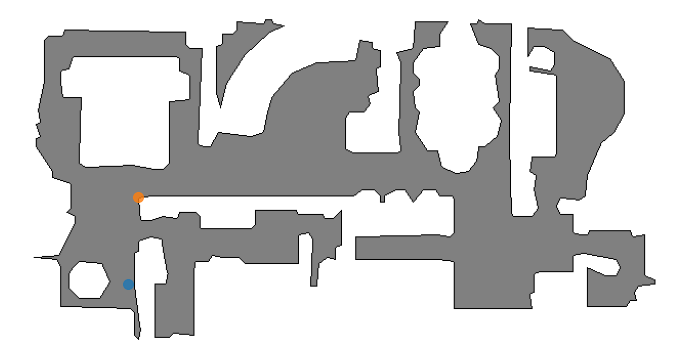

In [69]:
start, goal = generate_random_step()
display_objs([], key_points=[start, goal])

Let's examine the situation...

In [70]:
objs = visible_objects_looking_toward(start, goal)
len(objs)

10

== Object info ==
id: 0_8_160
obj category: 'picture'
obj region category: 'familyroom/lounge'
obj center: [-8.30908    1.2209699  1.28505  ]
obj sizes: [0.09793854 0.7896261  1.2433078 ]
== Spatial configuration info ==
View point: Region id: 0_8, region category: familyroom/lounge
Position: Region id: 0_0, region category: bedroom
lateral orientation: left
depth orientation: behind
position is near to obj: False
position is covered by the obj: False


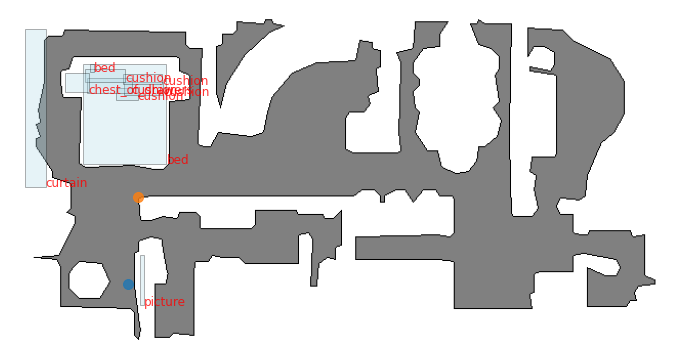

In [71]:
obj = objs[0]
print("== Object info ==")
print(obj_info(obj))
pos_info(goal, obj, start)
display_objs(objs[:10], key_points=[start, goal])

We also sample randomly a staring angle:

In [72]:
start_angle = random.uniform(0, 2 * math.pi)
print(start_angle)

4.798937463950548


Let's see the observations from the starting position and pose:

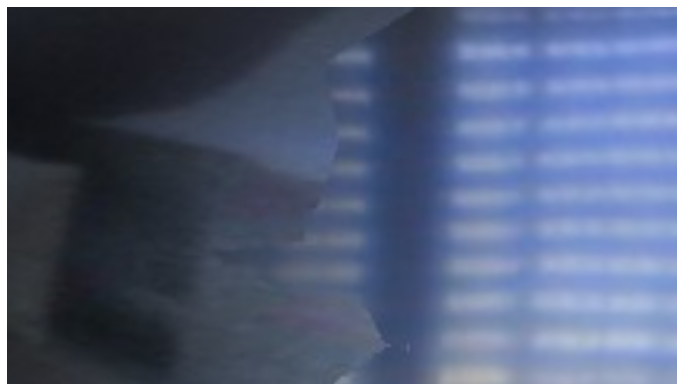

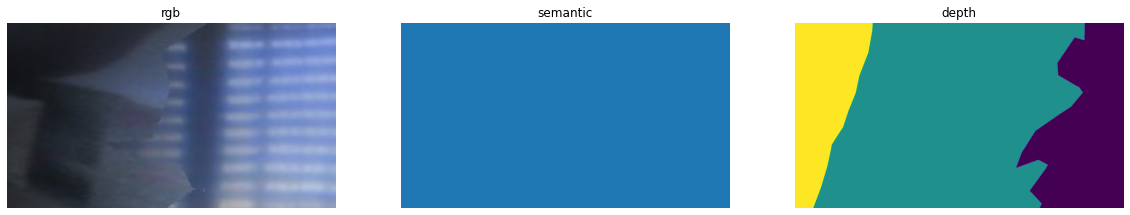

In [73]:
set_agent_position(start)
set_agent_angle(start_angle)
display_current_obs()

And the observations in the direction of the goal:

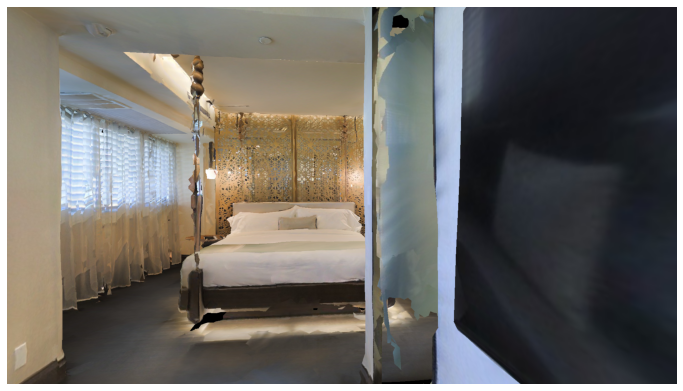

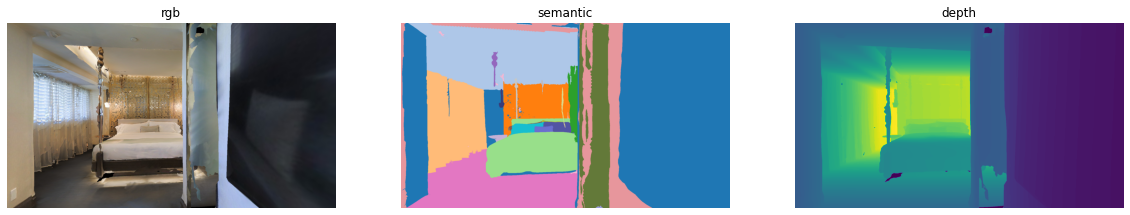

In [74]:
set_agent_angle(angle_toward(start, goal))
display_current_obs()

And, finally, the generated instruction:

In [77]:
print(instruction(start, start_angle, goal))

NameError: name 'key' is not defined